In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pylab as py

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 120

import sys
import pickle as pkl
from Signal import *
sys.path.append("../DetResponse/")
sys.path.append("../Utils/")
from Detector import *
from Plot_Histogram import *
from Signal import *

# KDE:
from kde.pykde import gaussian_kde
from sklearn.neighbors import KernelDensity
# from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


Test KDE package on evt-by-evt basis

In [2]:
# Compute weights and extract other informations:
def ComputeWeight(MCdict, SpectraPath, JfactorPath, channel, mass):
    nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}

    #PDF_variables
    array_recopsi = np.array([])
    array_recoE = np.array([])
    array_PID = np.array([])
    signal_w = np.array([])

    for nu_type in nu_types:
        loc = np.where( (MCdict["E_true"]<=mass) & (MCdict["nutype"]==pdg_encoding[nu_type]) )

        ##Sort all variables by increasing true_E values##
        ##NOTE: this is required for spectra interpolation
        # sort = MCdict["E_true"][loc].argsort()

        ##Simulation weight##
        genie_w = MCdict["w"][loc]

        ##Spectra interpolation##
        true_E = MCdict["E_true"][loc]
        dNdE = Interpolate_Spectra(SpectraPath, true_E, channel, mass)
        # print ("True_E first & last elements:", true_E[0], true_E[-1])
        # print ("True_E min & max:", min(true_E), max(true_E))
        # print ("Negative dNdE values:", np.where(dNdE<0)[0])

        ##Jfactor interpolation##
        #NOTE: input psi in deg!
        true_psi = MCdict["psi_true"][loc]
        Jpsi = Interpolate_Jfactor(JfactorPath, true_psi)
        # print ("True_psi min & max:", min(true_psi), max(true_psi))

        ##Signal weight##
        weight = (1./(2 * 4*math.pi * mass**2)) * genie_w * dNdE[nu_type] * Jpsi
        # print ("Len(weight):",len(weight))

        ##Reco variables:
        reco_psi = MCdict["psi_reco"][loc]
        reco_E = MCdict["E_reco"][loc]
        PID = MCdict["PID"][loc]

        ##group all nutype:
        array_recopsi = np.append(array_recopsi, reco_psi)
        array_recoE = np.append(array_recoE, reco_E)
        array_PID = np.append(array_PID, PID)
        signal_w = np.append(signal_w, weight)
    return array_PID, array_recopsi, array_recoE, signal_w






In [3]:
def kde_icecube(x, x_grid, bandwidth=0.03, **kwargs):
    """Kernel Density Estimation with icecube package"""

    if bandwidth == "adaptive":
        adaptive = True
        weight_adaptive_bw = True
        alpha = 0.3
        kde = gaussian_kde(x, **kwargs,adaptive=adaptive,
                                    weight_adaptive_bw=weight_adaptive_bw,alpha=alpha)
    else:
        kde = gaussian_kde(x, **kwargs)
        # for scipy: scale to try to match sklearn in case of scalar
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # divide the bandwidth by the sample standard deviation here.
        # https://stackoverflow.com/questions/21000140/relation-between-2d-kde-bandwidth-in-sklearn-vs-bandwidth-in-scipy
        # if (isinstance(bandwidth, str)==False): 
        #     bandwidth = bandwidth / x.std(ddof = 1)

    kde.set_bandwidth(bandwidth)
    return kde.evaluate(x_grid)


# def kde_statsmodels_u(x, x_grid, bandwidth=0.03, **kwargs):
#     """Univariate Kernel Density Estimation with Statsmodels"""
#     kde = KDEUnivariate(x)
#     kde.fit(bw=bandwidth, **kwargs)
#     return kde.evaluate(x_grid)
    
    
# def kde_statsmodels_m(x, x_grid, bandwidth=0.03, **kwargs):
#     """Multivariate Kernel Density Estimation with Statsmodels"""
#     kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
#                           var_type='c', **kwargs)
#     return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.03, weight=0, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x, sample_weight=weight)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid)
    return np.exp(log_pdf)
    # return kde_skl



In [4]:
def PDFwithKDE(MCdict, SpectraPath, JfactorPath, channel, mass, bw_method, psival, Eval,
    Psireco_edges, Ereco_edges, method="sklearn"):

    array_PID, array_recopsi, array_recoE, signal_w = ComputeWeight(MCdict, SpectraPath, JfactorPath, channel, mass)


    # Define PID cut:
    PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    pdf = np.zeros((3,len(Psireco_edges)-1, len(Ereco_edges)-1))
    i = 0
    sum = 0
    for pidbin in PID:
        print("Computing {} PID bin".format(pidbin))
        loc = np.where( ( array_PID >= pidbin[0]) & ( array_PID < pidbin[1]) )
        #PDF_variables
        recopsi = array_recopsi[loc]
        recoE = array_recoE[loc]
        weight = signal_w[loc]

        psiE_train = np.vstack([np.log(recopsi),np.log10(recoE)])

        #Evaluate points:
        ##Equal spacing in the final variables: Psi & log10(E)
        g_E, g_psi = np.meshgrid(Eval, psival)                      
        psi_eval = g_psi.flatten()
        E_eval = g_E.flatten()
        ##Evaluate the KDE in log(Psi)-log10E
        psiE_eval = np.vstack([np.log(psi_eval), np.log10(E_eval)])
        
        print ("Min & max psi_eval:", min(psi_eval),max(psi_eval))
        print ("Min &max E_eval:", np.min(E_eval),np.max(E_eval))
        
        ##Evaluate KDE##
        #In terms of log(psi)-log10(E)
        if method=="sklearn":
            kde_w = kde_sklearn(psiE_train.T, psiE_eval.T, bandwidth=bw_method, weight=weight)
            #Needs to be divided by evaluation angle
            kde_weight = kde_w.reshape(psi_eval.shape)/psi_eval 
        else:
            kde_w = kde_icecube(psiE_train, psiE_eval, bandwidth=bw_method, weights=weight)
            #Needs to be divided by evaluation angle
            kde_weight = kde_w/psi_eval


        ##Compute weight correction factor (in case multiple poine of evaluation in 1 bin)##
        ##Need to be corrected by Nevents in each bin##
        #-> in case evaluate several values points in each bin
        #Define grid with bin edges
        # edges_psi, edges_E = np.meshgrid(Psireco_edges,Ereco_edges)
        # edges_psiE = np.vstack([edges_psi.reshape(-1),edges_E.reshape(-1)])
        # #Evaluate correction to weight
        # corr = np.ones(len(psi_eval))
        # for j in range(len(edges_psiE[0])-1):
        #     if edges_psiE[0][j] >= edges_psiE[0][j+1]:
        #         continue
        #     loc = np.where(((edges_psiE[0][j]<=psi_eval) & (psi_eval<=edges_psiE[0][j+1])) & 
        #                    ((edges_psiE[1][j]<=E_eval) & (E_eval<=(edges_psiE[1][j+1]))))
        #     corr[loc] = len(psi_eval[loc])
        # kde_weight /= corr

        # H, v0_edges, v1_edges = np.histogram2d(psi_eval, E_eval,
        #                                     bins = (Psireco_edges, Ereco_edges),
        #                                     weights=kde_weight)

                                            
        # pdf[i] = H
        # sum += np.sum(kde_weight)                                  
        # i+=1
    return kde_weight



        

In [5]:
# Extract MC with OscNext cuts
MC = ExtractMC()

# Use precomputed spectra and jfactor
GC_dir = "/data/user/tchau/Sandbox/GC_OscNext"
Spectra = "{}/Spectra/PreComp/Spectra_ann_PPPC4_atEarth.pkl".format(GC_dir)
Jfactor = "{}/Spectra/PreComp/JFactor_NFW.pkl".format(GC_dir)

In [6]:
# Define binning edges and center
# E reco
Ereco_edges = pow(10., np.linspace(np.log10(1.), np.log10(1e3), 50+1))
Ereco_center = np.array([np.sqrt(Ereco_edges[i]*Ereco_edges[i+1]) for i in range(len(Ereco_edges) - 1)])
# Psi reco
Psireco_edges = np.linspace(0., 180., 18+1)
Psireco_center = np.array( [(Psireco_edges[i]+Psireco_edges[i+1])/2. for i in range(len(Psireco_edges)-1)] )
# Psireco_center = np.linspace(1e-3, 180., 5*18)



In [14]:
channel = "bb"
mass = 100

# PDF = PDFwithKDE(MC, Spectra, Jfactor, channel, mass, "adaptive", Psireco_center, Ereco_center,
#     Psireco_edges, Ereco_edges)

PDF = PDFwithKDE(MC, Spectra, Jfactor, channel, mass, 0.03, Psireco_center, Ereco_center,
    Psireco_edges, Ereco_edges, method="sklearn")

# around 5-10 minutes for normal bandwidth values, too long to run on cobalt for adaptive
# pkl.dump(PDF, open("./temp_evtbyevt_0.03bw_kde_18_50eval_18_50bin_kde.pkl", "wb"))    

Computing [0.0, 0.5] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991
Computing [0.5, 0.85] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991
Computing [0.85, 1] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991


In [25]:

PDF2 = PDFwithKDE(MC, Spectra, Jfactor, channel, mass, 0.03, Psireco_center, Ereco_center,
    Psireco_edges, Ereco_edges, method="sklearn")

# around 5-10 minutes for normal bandwidth values, too long to run on cobalt for adaptive
pkl.dump(PDF2, open("./temp_evtbyevt_0.03bw_kde_18_50eval_18_50bin_sklearn.pkl", "wb"))   


Computing [0.0, 0.5] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991
Computing [0.5, 0.85] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991
Computing [0.85, 1] PID bin
Min & max psi_eval: 5.0 175.0
Min &max E_eval: 1.0715193052376064 933.254300796991


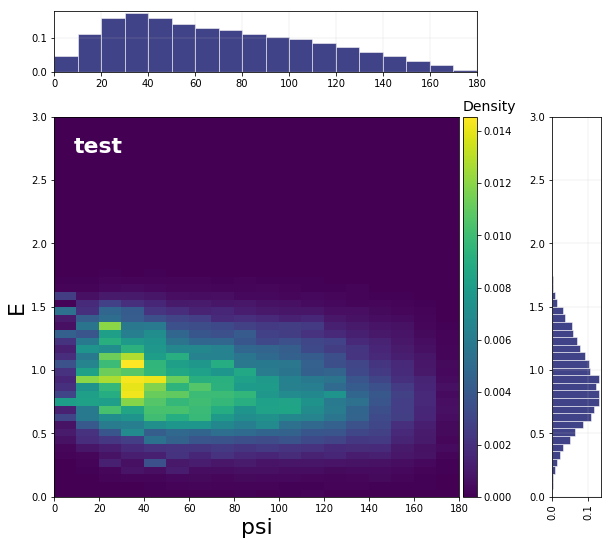

In [14]:
PDF = pkl.load(open("./temp_evtbyevt_0.03bw_kde_18_50eval_18_50bin_sklearn.pkl", "rb"))  
PDF2 = pkl.load(open("./temp_evtbyevt_0.03bw_kde_18_50eval_18_50bin_kde.pkl", "rb"))   


plot_projections(PDF2[0], [Psireco_edges, np.log10(Ereco_edges)], "psi", "E", "test")

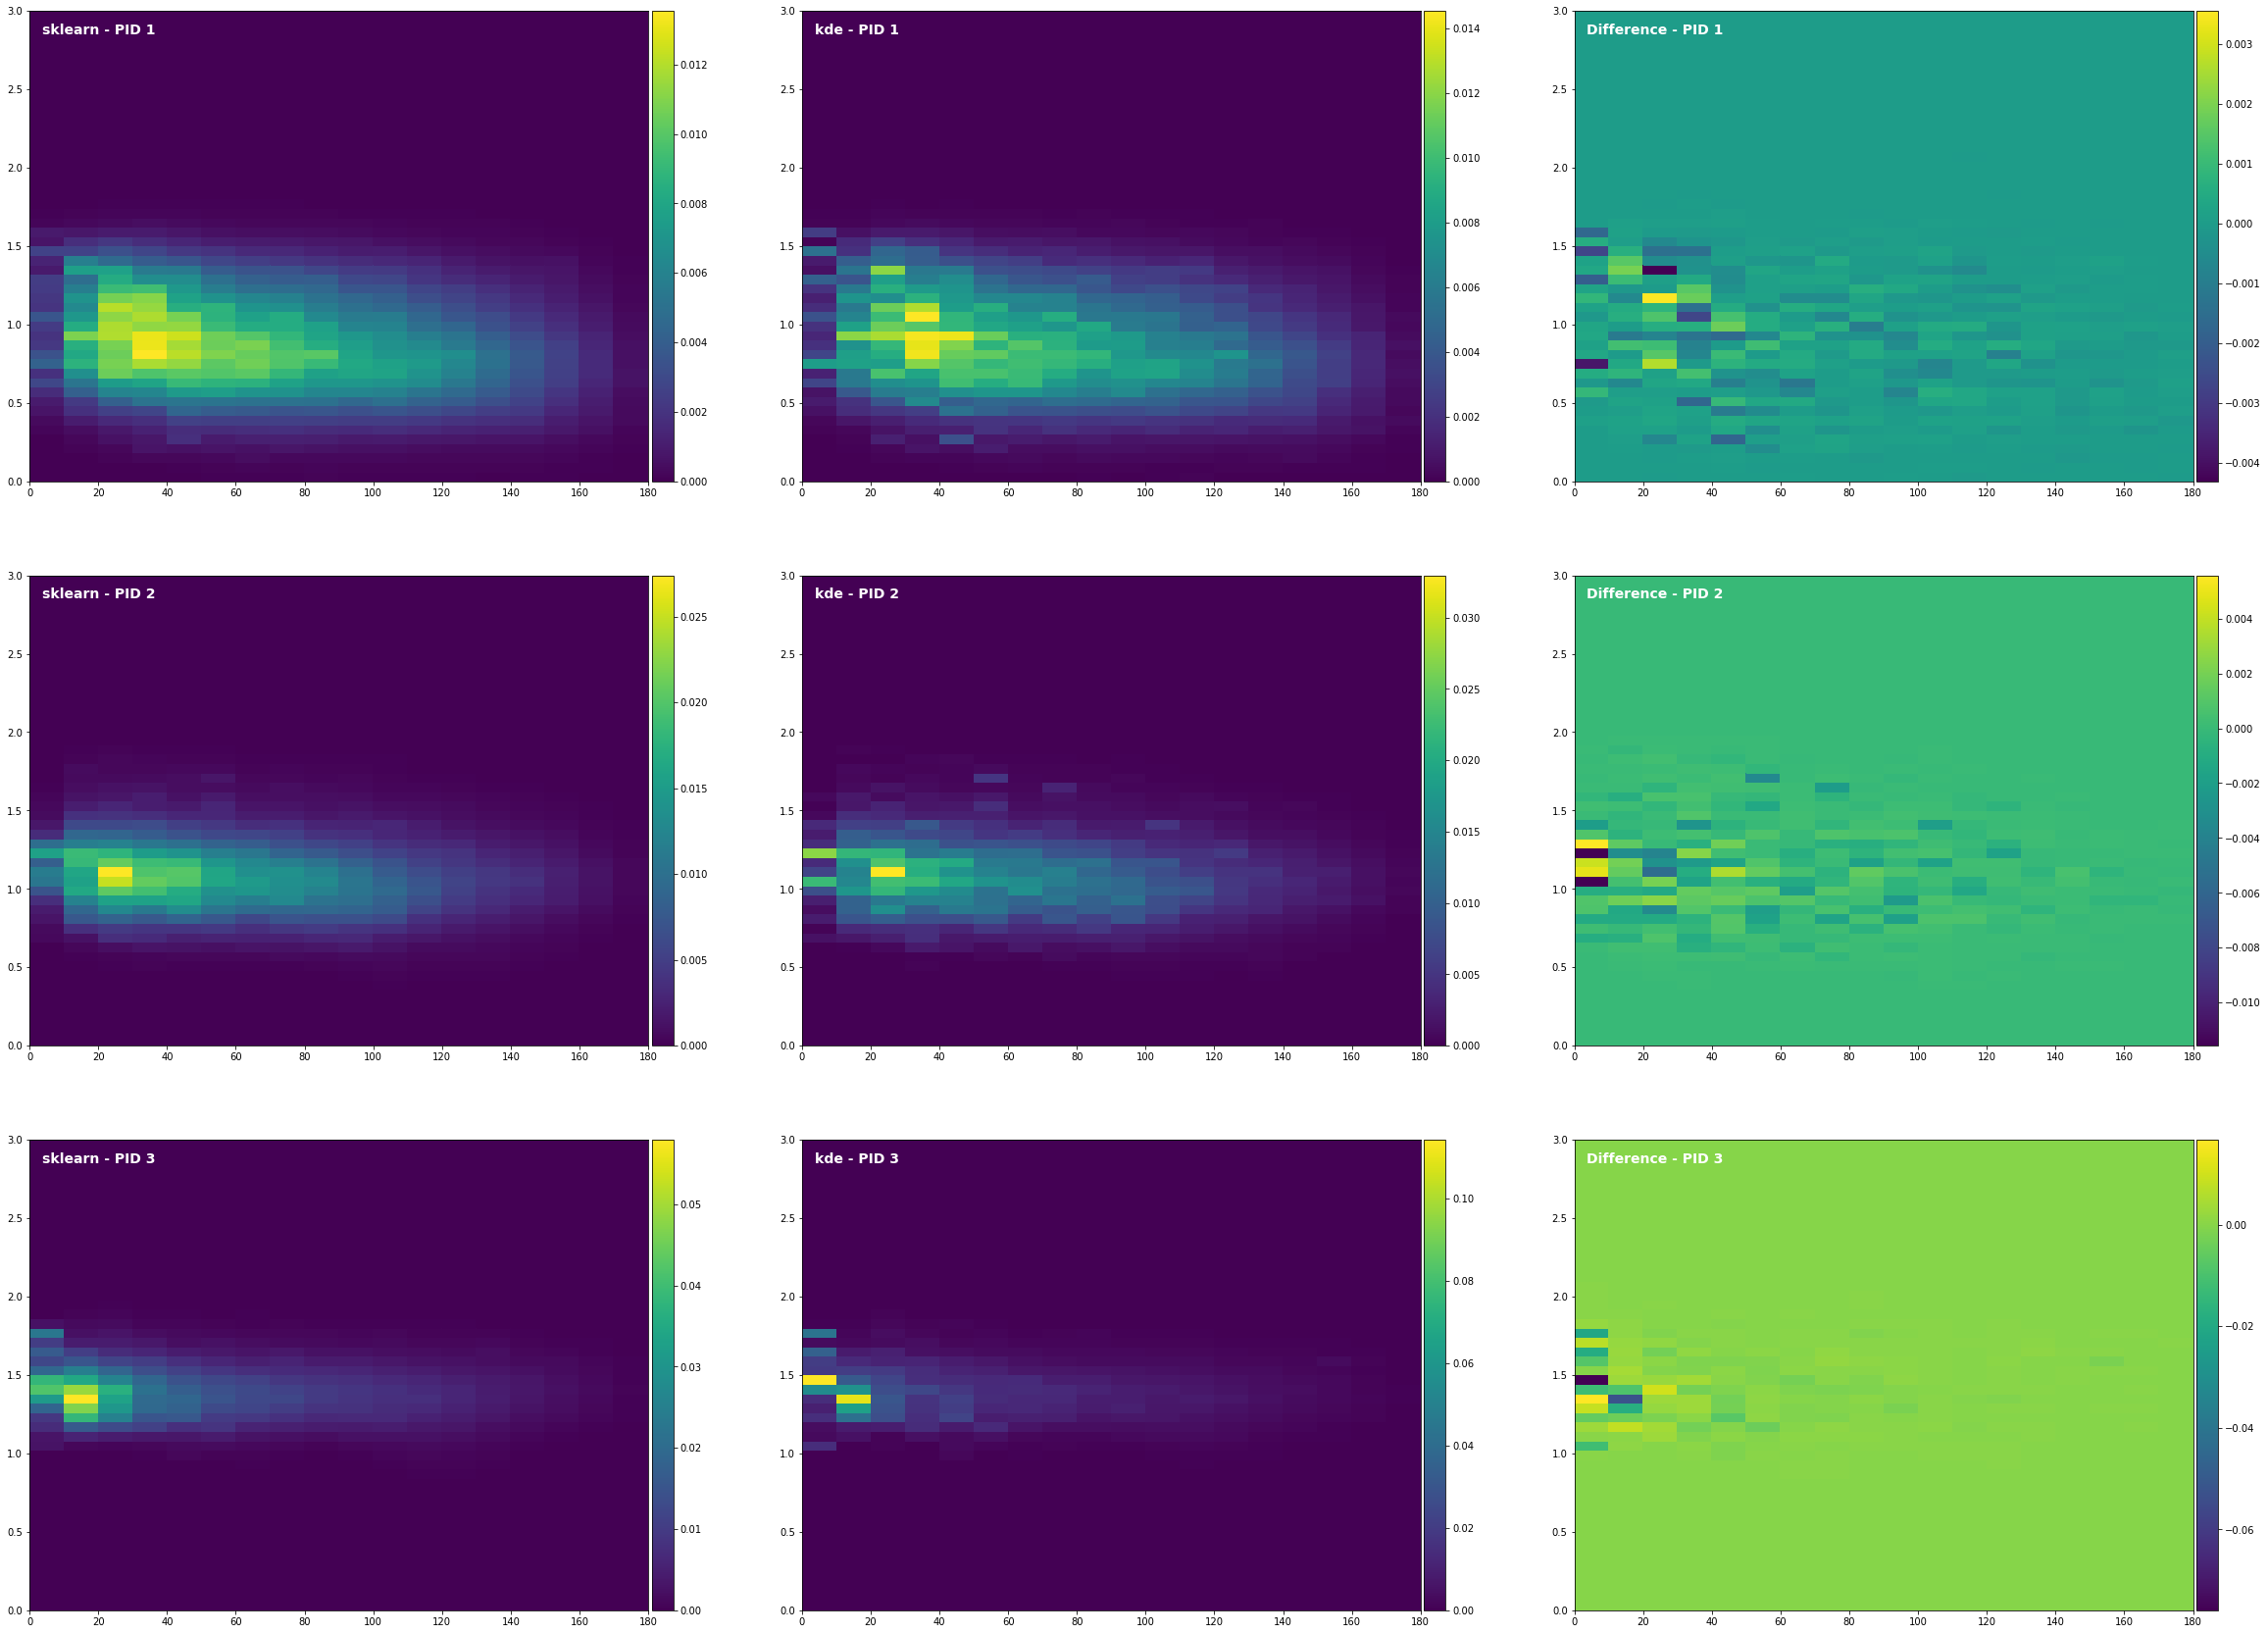

In [16]:
Plot2D_sidebyside_diff(PDF, PDF2,  [Psireco_edges, np.log10(Ereco_edges)], "sklearn", "kde")
# 0.03 in sklearn more smooth than from the kde package


KDE on Response matrix:
KDE for each nutype->PID


In [7]:
def KDE_RespMatrix(MCcut, Bin, bw_method, method="kde"):
    # Separate MC by each channel nutype->PID:
    # nu_types = ["nu_e", "nu_mu", "nu_tau", "nu_e_bar", "nu_mu_bar", "nu_tau_bar"]
    nu_types = ["nu_e"]

    pdg_encoding = {"nu_e":12, "nu_mu":14, "nu_tau":16, "nu_e_bar":-12, "nu_mu_bar":-14, "nu_tau_bar":-16}
    # PID = [[0.,0.5],[0.5, 0.85],[0.85, 1]]
    PID = [[0.,0.5]]

    pid_id = 0
    Resp = dict()
    pidbin = 0
    for pid in PID:
        print("Computing {} PID bin".format(pid))
        Resp[pidbin] = dict()
        pidbin += 1
        for nu_type in nu_types:
            print("----{}".format(nu_type))

            loc = np.where(  (MCcut["nutype"]==pdg_encoding[nu_type]) & (MCcut["PID"]>=pid[0])
                            & (MCcut["PID"]<pid[1]) )
        
            #Extract MC events: 
            #NOTE: input psi in deg!
            psitrue = MCcut["psi_true"][loc]
            Etrue = MCcut["E_true"][loc]
            psireco = MCcut["psi_reco"][loc]
            Ereco = MCcut["E_reco"][loc]
            w = MCcut["w"][loc]
                
            psiE_train = np.vstack([np.log(psitrue), Etrue, np.log(psireco), np.log10(Ereco)])
            
            #Evaluate points:
            ##Equal spacing in the final variables: reco Psi & log10(E), true psi and true E
            trueEeval = Bin["true_energy_center"]
            truePsieval = Bin["true_psi_center"]
            recoEeval = Bin["reco_energy_center"]
            recoPsieval = Bin["reco_psi_center"]

            g_psi_true, g_energy_true, g_psi_reco, g_energy_reco = np.meshgrid(truePsieval, trueEeval,
                                                                    recoPsieval, recoEeval)                      
            psi_eval_true = g_psi_true.T.flatten()
            E_eval_true = g_energy_true.T.flatten()
            psi_eval_reco = g_psi_reco.T.flatten()
            E_eval_reco = g_energy_reco.T.flatten()

            ##Evaluate the KDE in log(Psi)-log10E
            psiE_eval = np.vstack([np.log(psi_eval_true), np.log10(E_eval_true), 
                                np.log(psi_eval_reco), np.log10(E_eval_reco)])
            print("Evaluating KDE.....")    
            if method=="sklearn":
                kde_w = kde_sklearn(psiE_train.T, psiE_eval.T, bandwidth=bw_method, weight=w)
                #Needs to be divided by evaluation angle
                kde_weight = kde_w.reshape(psi_eval_true.shape)/(psi_eval_true* psi_eval_reco* E_eval_true)
            else:
                kde_w = kde_icecube(psiE_train, psiE_eval, bandwidth=bw_method, weights=w)
                #Needs to be divided by evaluation angle
                kde_weight = kde_w/(psi_eval_true* psi_eval_reco* E_eval_true)

            # Fill into histogram:
            Psitrue_edges = Bin["true_psi_edges"]
            Etrue_edges = Bin["true_energy_edges"]
            Psireco_edges = Bin["reco_psi_edges"]
            Ereco_edges = Bin["reco_energy_edges"]

            H, edges = np.histogramdd((psi_eval_true, E_eval_true, psi_eval_reco, E_eval_reco),
                                        bins = (Psitrue_edges, Etrue_edges, Psireco_edges, Ereco_edges),
                                        weights=kde_weight)
            Resp[pid][nu_type] = H
    return Resp                 
                
    

In [8]:
# mass: true binning depends on the DM mass
mass = 100

# Binning:
# E true
Etrue_center = np.linspace(1., mass, 100)
Ewidth = (mass-1.)/(100.-1.)
Etrue_edges = [E - Ewidth/2. for E in Etrue_center]
Etrue_edges.append(Etrue_center[-1] + Ewidth/2.)
# Psi true
Psitrue_edges = np.linspace(0, 180, 51)
Psiwidth = 180./50.
Psitrue_center = np.array([Psitrue_edges[i]+Psiwidth/2. for i in range(len(Psitrue_edges)-1)])
# E reco
Ereco_edges = pow(10., np.linspace(np.log10(1.), np.log10(1e3), 50+1))
Ereco_center = np.array([np.sqrt(Ereco_edges[i]*Ereco_edges[i+1]) for i in range(len(Ereco_edges) - 1)])
# Psi reco
Psireco_edges = np.linspace(0., 180., 18+1)
Psireco_center = np.array( [(Psireco_edges[i]+Psireco_edges[i+1])/2. for i in range(len(Psireco_edges)-1)] )

# PID
PID_edges = np.array([0.,0.5,0.85,1.])
PID_center = np.array( [(PID_edges[i]+PID_edges[i+1])/2. for i in range(len(PID_edges)-1)] )

Bin = GroupBinning(Etrue_edges, Psitrue_edges, Etrue_center, Psitrue_center,
                Ereco_edges, Psireco_edges, Ereco_center, Psireco_center, PID_edges, PID_center)

In [9]:
Resp = KDE_RespMatrix(MC, Bin, "scott", method="kde")

Computing [0.0, 0.5] PID bin
----nu_e
Evaluating KDE.....


KeyboardInterrupt: 